In [1]:
import os
import shutil
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from official.nlp import optimization  # to create AdamW optimizer

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
tf.get_logger().setLevel('ERROR')

In [2]:
main_data=pd.read_csv("sarcasm_v2\\GEN-sarc-notsarc.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
data["class"] = data["class"].map(classes)
data

,class,text
0,0,"If that's true, then Freedom of Speech is doom..."
1,0,Neener neener - is it time to go in from the p...
2,0,"Just like the plastic gun fear, the armour pie..."
3,0,So geology is a religion because we weren't he...
4,0,Well done Monty. Mark that up as your first ev...
...,...,...
6515,1,depends on when the baby bird died. run alon...
6516,1,"ok, sheesh, to clarify, women who arent aborti..."
6517,1,so.. eh?? hows this sound? will it fly w...
6518,1,"I think we should put to a vote, the right of ..."


In [3]:
ps = PorterStemmer()
nltk.download('stopwords')
def clean_text(text): 
    ptext = re.sub('http[s]?://\S+', '', text)
    ptext = re.sub('[^0-9a-zA-Z]', ' ', ptext)
    ptext = ptext.lower()
    
    ptext = re.sub(r'(\s)emoticonX\w+', '', ptext)
    
    ptext = ptext.split()
    ptext = [ps.stem(word) for word in ptext if not word in stopwords.words('english')]
    
    ptext = ' '.join(ptext)
    
    return ptext
data['text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Taha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
X=data['text']
y=data['class']
X=np.array(X)
y=np.asarray(y).astype('int32')#.reshape((-1,1))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
text_test = ["If that's true, then Freedom of Speech is doomed. Harassment is subjective. Now I can claim that a book I don't like is harassing me, and it will be banned."]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2065 2008 1005 1055 2995 1010 2059 4071 1997 4613 2003]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [10]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9965645   0.7668134  -0.3997189   0.38805524 -0.33479023  0.87939006
  0.993136   -0.97671133 -0.64766103 -0.9965118  -0.08223002 -0.9970651 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.14419428  0.48491472  1.0194478  ... -0.98393357 -0.646164
   1.3295859 ]
 [-0.16498578 -0.17995638 -0.7595989  ... -1.5773429   0.05148263
   0.6241291 ]
 [ 0.6609399  -0.3913831   0.05011945 ... -0.9759875   0.08927511
   0.00197429]
 ...
 [-1.2372708   0.11815276  0.70584744 ... -0.6370288  -0.96404576
  -0.637064  ]
 [-0.77888143  0.47244895 -0.00934209 ...  0.18617362  0.23353843
   0.42738432]
 [-0.39843145  1.029639   -0.19418497 ... -0.40336183  0.14866307
   0.41284454]]


In [33]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [34]:
classifier_model = build_classifier_model()

In [35]:
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5607437]], shape=(1, 1), dtype=float32)


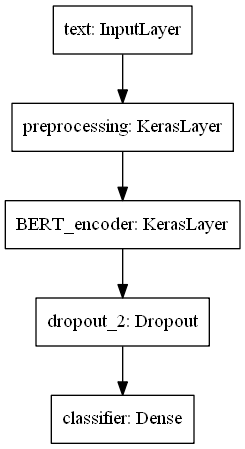

In [36]:
tf.keras.utils.plot_model(classifier_model)

In [37]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [39]:
train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [40]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [41]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [42]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
163/163 [==============================] - 1543s 9s/step - loss: 0.6170 - binary_accuracy: 0.6325 - val_loss: 0.5377 - val_binary_accuracy: 0.7239
Epoch 2/5
163/163 [==============================] - 1303s 8s/step - loss: 0.5258 - binary_accuracy: 0.7278 - val_loss: 0.5436 - val_binary_accuracy: 0.7347
Epoch 3/5
163/163 [==============================] - 1293s 8s/step - loss: 0.4706 - binary_accuracy: 0.7671 - val_loss: 0.5546 - val_binary_accuracy: 0.7308
Epoch 4/5
163/163 [==============================] - 1368s 8s/step - loss: 0.4200 - binary_accuracy: 0.8020 - val_loss: 0.5921 - val_binary_accuracy: 0.7262
Epoch 5/5
163/163 [==============================] - 1450s 9s/step - loss: 0.3826 - binary_accuracy: 0.8267 - val_loss: 0.5761 - val_binary_accuracy: 0.7209


In [43]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

41/41 [==============================] - 92s 2s/step - loss: 0.5761 - binary_accuracy: 0.7209
Loss: 0.5760964751243591
Accuracy: 0.7208588719367981


In [54]:
test_data=pd.read_csv("sarcasm_v2\\HYP-sarc-notsarc.csv")
test_data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
test_data["class"] = test_data["class"].map(classes)
test_data

,class,text
0,0,have no predators to fear? check. who said we ...
1,0,2 hours? damn! that book took me a good 2 day...
2,0,you never played myst? damn!!! i must be reall...
3,0,"Well, if Genesis was in fact true, then we wou..."
4,0,Just making sure that everybody is aware of hi...
...,...,...
1159,1,you really believed me? wow! i never knew i ha...
1160,1,please tell me you're kidding. these bowling b...
1161,1,you're kidding. just because your life is 'a f...
1162,1,the evidence that is provided to you is not en...


In [55]:
test_data['text'] = test_data['text'].apply(clean_text)

In [56]:
test_X=test_data['text']
test_y=test_data['class']
test_X=np.array(test_X)
test_y=np.asarray(test_y).astype('int32')

In [57]:
test_tf = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(32)

In [58]:
loss, accuracy = classifier_model.evaluate(test_tf)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

37/37 [==============================] - 73s 2s/step - loss: 0.9183 - binary_accuracy: 0.6271
Loss: 0.9183292984962463
Accuracy: 0.6271477937698364


In [59]:
test_data2=pd.read_csv("sarcasm_v2\\RQ-sarc-notsarc.csv")
test_data2.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
test_data2["class"] = test_data2["class"].map(classes)
test_data2

,class,text
0,0,"Archie, the ONLY issue that gays don't have a ..."
1,0,"No, not really. All that is different is the n..."
2,0,It's ashame that everyone keeps looking for th...
3,0,"Almost? Usually, that is true, and it involves..."
4,0,And so have animals. Plants have been wiped ou...
...,...,...
1697,1,"Tell me genius, how is me accurately and corre..."
1698,1,So you think it is a good idea for public scho...
1699,1,"Now settle down charlie, and try to think rati..."
1700,1,The VPC has a political agenda. The FBI? That ...


In [60]:
test_data2['text'] = test_data2['text'].apply(clean_text)
test2_X=test_data2['text']
test2_y=test_data2['class']
test2_X=np.array(test2_X)
test2_y=np.asarray(test2_y).astype('int32')

In [61]:
test2_tf = tf.data.Dataset.from_tensor_slices((test2_X,test2_y)).batch(32)
loss, accuracy = classifier_model.evaluate(test2_tf)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

54/54 [==============================] - 109s 2s/step - loss: 0.6165 - binary_accuracy: 0.7368
Loss: 0.6165244579315186
Accuracy: 0.7367802858352661
